# Transdermal Drug Delivery of Verapamil

Исследовалась модель распространения вещества при введении микроиглы под кожу.

Решался второй закон Фика с проникновением вещества в кровь:

$c = D \cdot \nabla^2 c + (K_{21}\cdot c_{b} \cdot {{V_b} \over {V_t}} - K_{12} c)$

$c_{b} = -K_e \cdot c_{b} + (K_{12}c\cdot {{V_t} \over {V_b}} - K_{21}c_{b})$

Все коэффициенты брались из статьи Transdermal drug delivery by microneedles: does skin metabolism matter?  Al-Qallaf et al.

Были промоделированы 2D и 3D случаи

# 2D случай

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat

In [6]:
Vb = {
    'And_2d_mm':2.63,
    'And_2d_nm':2.63,
    'Eich_2d_mm':27.39,
    'Eich_2d_nm':27.39,
    'Koike_2d_mm':6.47,
    'Koike_2d_nm':6.47
}

In [45]:
data2d = loadmat('all_2d.mat')
data3d = loadmat('A_m-m.mat')
constants = loadmat('add.mat')
C2d_time = data2d['And_2d_mm'][0][0][0]
Cb2d_time = data2d['And_2d_mm'][0][0][1]
C3d_time = data3d['And1'][0][0][0]
Cb3d_time = data3d['And1'][0][0][1]

In [5]:
D = 7*10**(-8)
dx = constants['dx'][0][0]
dy = constants['dy'][0][0]
dz = constants['dz'][0][0]

Посчитаем концентрацию в крови

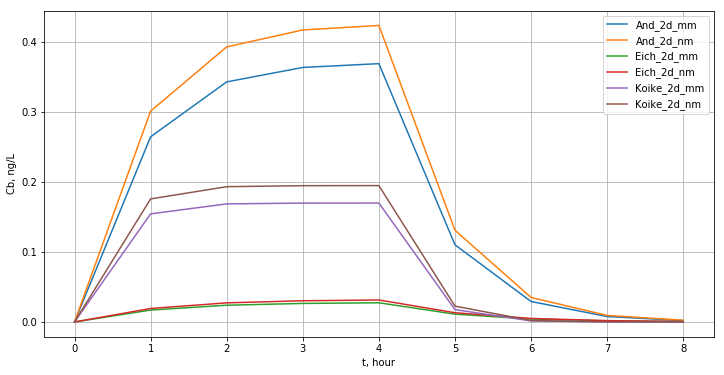

In [23]:
plt.figure(figsize=(12,6))
for key in ['And_2d_mm','And_2d_nm','Eich_2d_mm','Eich_2d_nm','Koike_2d_mm','Koike_2d_nm']:
    Cb_time = data[key][0][0][1]
    cb_dyn = []
    for cb in Cb_time:
        cb_dyn.append(np.sum(cb)*dx*dy*dz*9/Vb[key]/1e-5)
    plt.plot(cb_dyn, label=key)
plt.legend()
plt.grid()
plt.ylabel(r'Cb, ng/L');
plt.xlabel(r't, hour');

И количество поступившего вещества

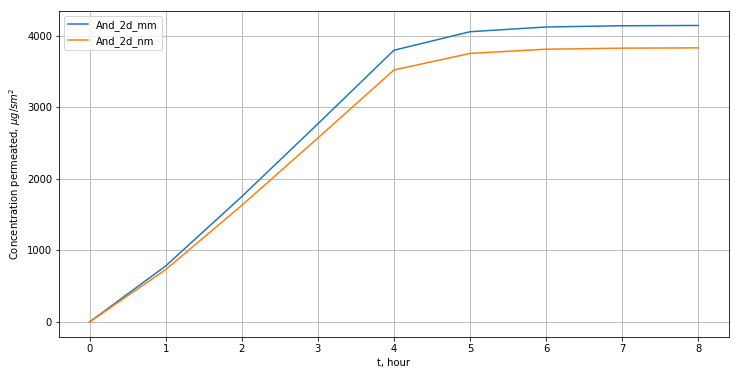

In [35]:
plt.figure(figsize=(12,6))
for key in ['And_2d_mm','And_2d_nm']:
    C_time = data[key][0][0][1]
    fluxes = []
    c_permeated = [0]
    c = C_time[0]
    for c in C_time[1:]:
        flux = -D*np.sum((c[11]-c[9])[20:29]*dy/dx*1000)/dy/9
        c_permeated.append(flux*3600+c_permeated[-1])
    plt.plot(c_permeated, label=key)
plt.legend()
plt.grid()
plt.ylabel(r'Concentration permeated, $\mu g/sm^2$');
plt.xlabel(r't, hour');

Картина течения в момент t=3ч

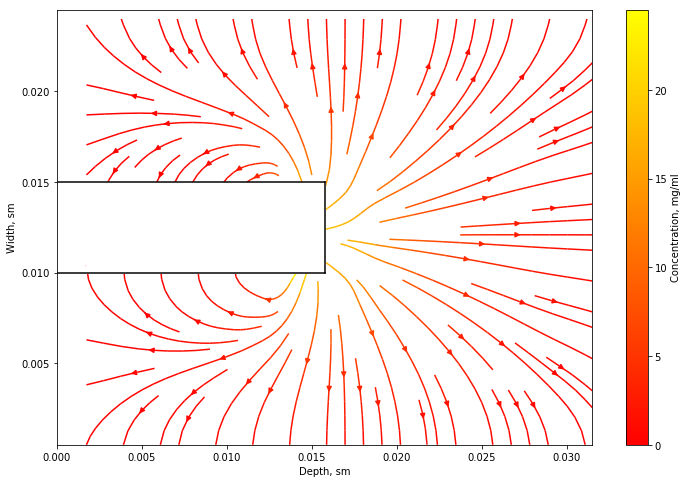

In [43]:
x = np.arange(0, 0.035,dx)
y = np.arange(0, 0.025, dy)

c_temp = data['And_2d_mm'][0][0][1][3]

gradX = []
for i in range(1,19):
    gradX.append(-D*(c_temp[i+1]-c_temp[i-1])/dx)
gradX = np.array(gradX)[:,1:-1]

gradY = []
for i in range(1,49):
    gradY.append(-D*(c_temp[:,i+1]-c_temp[:,i-1])/dy)
gradY = np.array(gradY).T[1:-1,:]

# gradX[0:9,:]=0
# gradY[0:9,:]=0

l = 9*0.00175
fig0, ax0 = plt.subplots()
fig0.set_size_inches(12,8)
strm = ax0.streamplot(x[1:-1], y[1:-1], gradX.T, gradY.T, color=c_temp.T[1:-1,1:-1],
                     cmap=plt.cm.autumn)
cbar = fig0.colorbar(strm.lines)
cbar.set_label('Concentration, mg/ml')
plt.fill_between([0.00175, l], [0.01,0.01], [0.015,0.015], color='white', zorder=100)
plt.plot([0.0001, l], [0.01,0.01], '-k', zorder=101)
plt.plot([0.0001, l], [0.015,0.015], '-k', zorder=101)
plt.plot([l, l], [0.01,0.015],'-k', zorder=101)
plt.xlim(0.)
plt.ylim(dy, 0.025-dy)
plt.xlabel('Depth, sm')
plt.ylabel('Width, sm')
plt.show()

Линии построены против направления градиента концентрации

# 3D случай

Для сравнения 2D и 3D использовались коэффициенты для Andersen

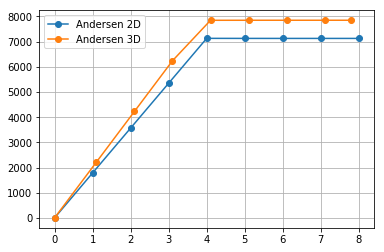

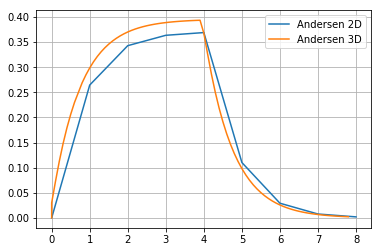

In [57]:
i_eff=0
times1  = []
fluxes1 = []
for t_idx, c in enumerate(C2d_time):
        fluxes1.append(-D*np.sum((c[11+i_eff]-c[9+i_eff])[20:29]/dx/9*1e3))
        times1.append(t_idx)

c_permeated1 = [0]
for i in range(1, len(times1)):
    c_permeated1.append(
        fluxes1[i]*(times1[i]-times1[i-1])*3600 + c_permeated1[-1]
    )

times2  = []
fluxes2 = []
for t_idx, c in enumerate(C3d_time):
    if t_idx != 7:
        fluxes2.append(-D*np.sum((c[11+i_eff]-c[9+i_eff])[20:29,20:29]/dx/81*1e3))
        times2.append(t_idx*0.1)

c_permeated2 = [0]
for i in range(1, len(times2)):
    c_permeated2.append(
        fluxes2[i]*(times2[i]-times2[i-1])*3600 + c_permeated2[-1]
    )

plt.plot(times1,c_permeated1, 'o-', label='Andersen 2D')
plt.plot(times2[::10]+[times2[-1]],c_permeated2[::10]+[c_permeated2[-1]], 'o-', label='Andersen 3D')
plt.legend()
plt.grid()
plt.show()

cb_din1 = [0]
ts1 = [0]
for t_idx, cb in enumerate(Cb2d_time):
        cb_din1.append(
            np.sum(cb)*dx*dy*dz*9/1e-5/Vb['And_2d_mm']
        )
        ts1.append(t_idx)

cb_din2 = [0]
ts2 = [0]
for t_idx, cb in enumerate(Cb3d_time):
    if t_idx != 7:
        cb_din2.append(
            np.sum(cb)*dx*dy*dz/1e-5/Vb['And_2d_mm']
        )
        ts2.append(t_idx*0.1)

plt.plot(ts1, cb_din1, label='Andersen 2D')
plt.plot(ts2, cb_din2, label='Andersen 3D')
plt.legend()
plt.grid()
plt.show()